# COSI 107 Report Demonstration

## Author: Michelangelo Zampieri 

This notebook contains the code for the demonstration section in my report for COSI 107 Intro to Computer Security. 

Here I load the CNN created earlier and execute the attack. 

Import needed libraries

In [83]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import foolbox as fb 
from torchvision.datasets import MNIST

Load the model

In [84]:
model_path = './models/mnist_cnn.pth'
if os.path.exists(model_path):
    model = torch.load(model_path)
else:
    raise FileNotFoundError(f"Model file {model_path} not found.")

Redefine the model as before

In [85]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.net = nn.Sequential(
            nn.Conv2d(1, 32, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(32, 64, 3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(64 * 7 * 7, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        return self.net(x)

Load the weights from the original model

In [86]:
# Load model and weights
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN().to(device)
model.load_state_dict(torch.load("./models/mnist_cnn.pth", map_location=device))
model.eval()
print("Model loaded successfully")

Model loaded successfully


Load the MNIST test dataset

In [87]:
test_transform = transforms.ToTensor()

test_dataset = datasets.MNIST(root="./data", train=False, transform=test_transform, download=True)
test_loader = DataLoader(test_dataset, batch_size=100, shuffle=True)

images, labels = next(iter(test_loader))
images, labels = images.to(device), labels.to(device)

Wrap the model with Foolbox this is how the attack will be created

In [88]:
fmodel = fb.PyTorchModel(
    model,
    bounds=(0, 1),
    preprocessing={"mean": 0.1307, "std": 0.3081},  # MNIST normalization
)

Initialize counter

In [89]:
total = 0
adv_correct = 0
clean_correct = 0

Define and execute the attack

In [90]:
# Fast Gradient Sign Method (FGSM) attack
attack = fb.attacks.FGSM()
eps = 0.15

for images, labels in test_loader:
    images, labels = images.to(device), labels.to(device)

    # Clean predictions
    with torch.no_grad():
        clean_preds = model(images).argmax(dim=1)
        clean_correct += (clean_preds == labels).sum().item()

    # Adversarial attack
    raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=eps)

    with torch.no_grad():
        adv_preds = model(clipped).argmax(dim=1)
        adv_correct += (adv_preds == labels).sum().item()

    total += labels.size(0)

# Accuracy results
print(f"Clean Accuracy:       {clean_correct / total:.2%} ({clean_correct}/{total})")
print(f"Adversarial Accuracy: {adv_correct / total:.2%} ({adv_correct}/{total})")

Clean Accuracy:       98.79% (9879/10000)
Adversarial Accuracy: 67.50% (6750/10000)


Make predictions on the new data

In [91]:
# Make predictions on adversarial examples
with torch.no_grad():
    adv_preds = model(clipped).argmax(dim=1)
    adv_correct = (adv_preds == labels).sum().item()
    total = labels.size(0)
    print(f"Adversarial Accuracy: {adv_correct / total:.2%} ({adv_correct}/{total})")
    
# Save adversarial examples
output_dir = './adversarial_examples'
os.makedirs(output_dir, exist_ok=True)
for i in range(len(clipped)):
    img = clipped[i].cpu().numpy().squeeze()
    label = labels[i].item()
    adv_pred = adv_preds[i].item()
    plt.imsave(os.path.join(output_dir, f"adv_{i}_label_{label}_pred_{adv_pred}.png"), img, cmap='gray')

Adversarial Accuracy: 72.00% (72/100)


Function to predict the images

In [92]:
# Plot the predictions
def plot_images(images, labels, predictions=None):
    plt.figure(figsize=(10, 10))
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        if predictions is not None:
            title = f"True: {labels[i]}, Pred: {predictions[i]}"
        else:
            title = f"Label: {labels[i]}"
        ax.set_title(title)
        ax.axis('off')
    plt.show()

Compare clean and adv images

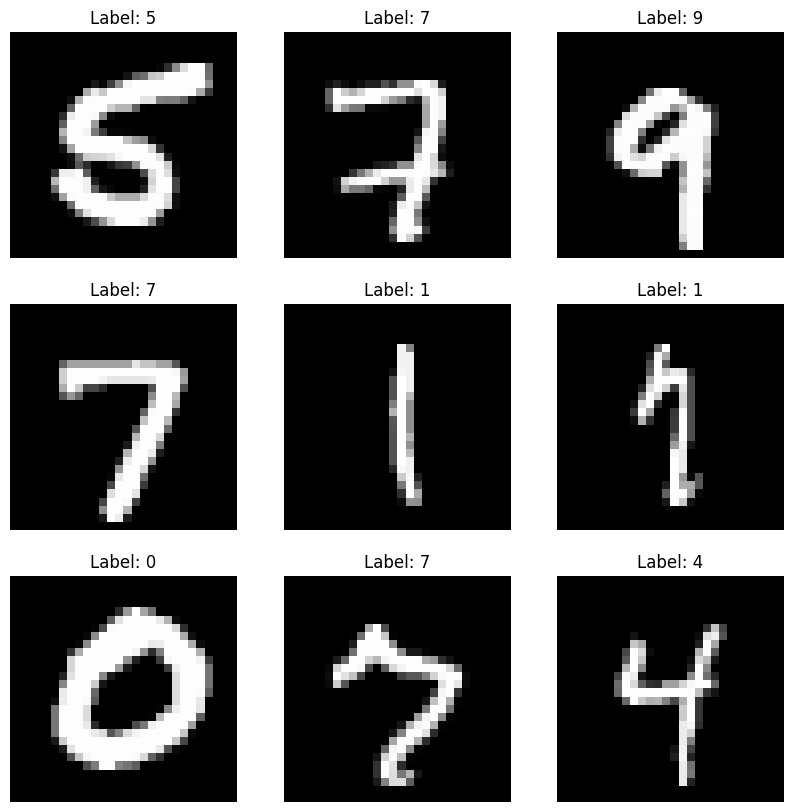

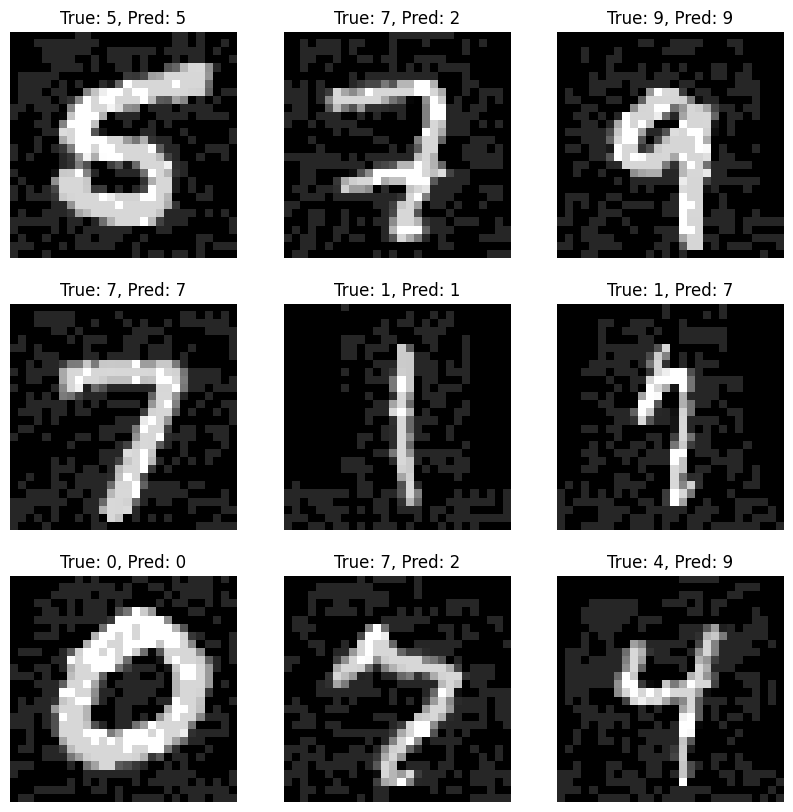

In [93]:
# Plot clean images
plot_images(images.cpu(), labels.cpu())
# Plot adversarial images
plot_images(clipped.cpu(), labels.cpu(), adv_preds.cpu())

Confusion matrix 

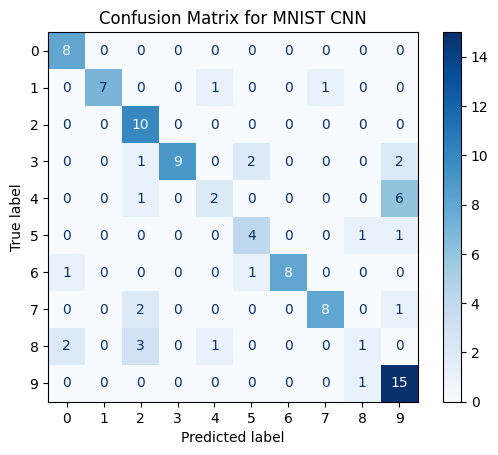

In [94]:
# Confusion matrix
cm = confusion_matrix(labels.cpu(), adv_preds.cpu())
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[i for i in range(10)])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix for MNIST CNN")
plt.show()

The confusion matrix was made on a smaller subsection this time bit it still shows good resuts. No one instance stands out particulary.

Function to plot the adv images

In [95]:
def plot_adversarial_examples(images, adv_images, labels, predictions, adv_predictions, is_adv, num_show=10):
    images = images.cpu().detach()
    adv_images = adv_images.cpu().detach()
    labels = labels.cpu().numpy()
    predictions = predictions.cpu().numpy()
    adv_predictions = adv_predictions.cpu().numpy()
    is_adv = is_adv.cpu().numpy()

    plt.figure(figsize=(12, 4 * num_show))
    for i in range(num_show):
        # Original image
        plt.subplot(num_show, 2, 2 * i + 1)
        plt.imshow(images[i][0], cmap='gray')
        plt.title(f"Original\nTrue: {labels[i]} | Pred: {predictions[i]}")
        plt.axis('off')

        # Adversarial image
        plt.subplot(num_show, 2, 2 * i + 2)
        plt.imshow(adv_images[i][0], cmap='gray')
        plt.title(f"Adversarial\nAdv Pred: {adv_predictions[i]} | Fooled: {is_adv[i]}")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

Plotting the adv images

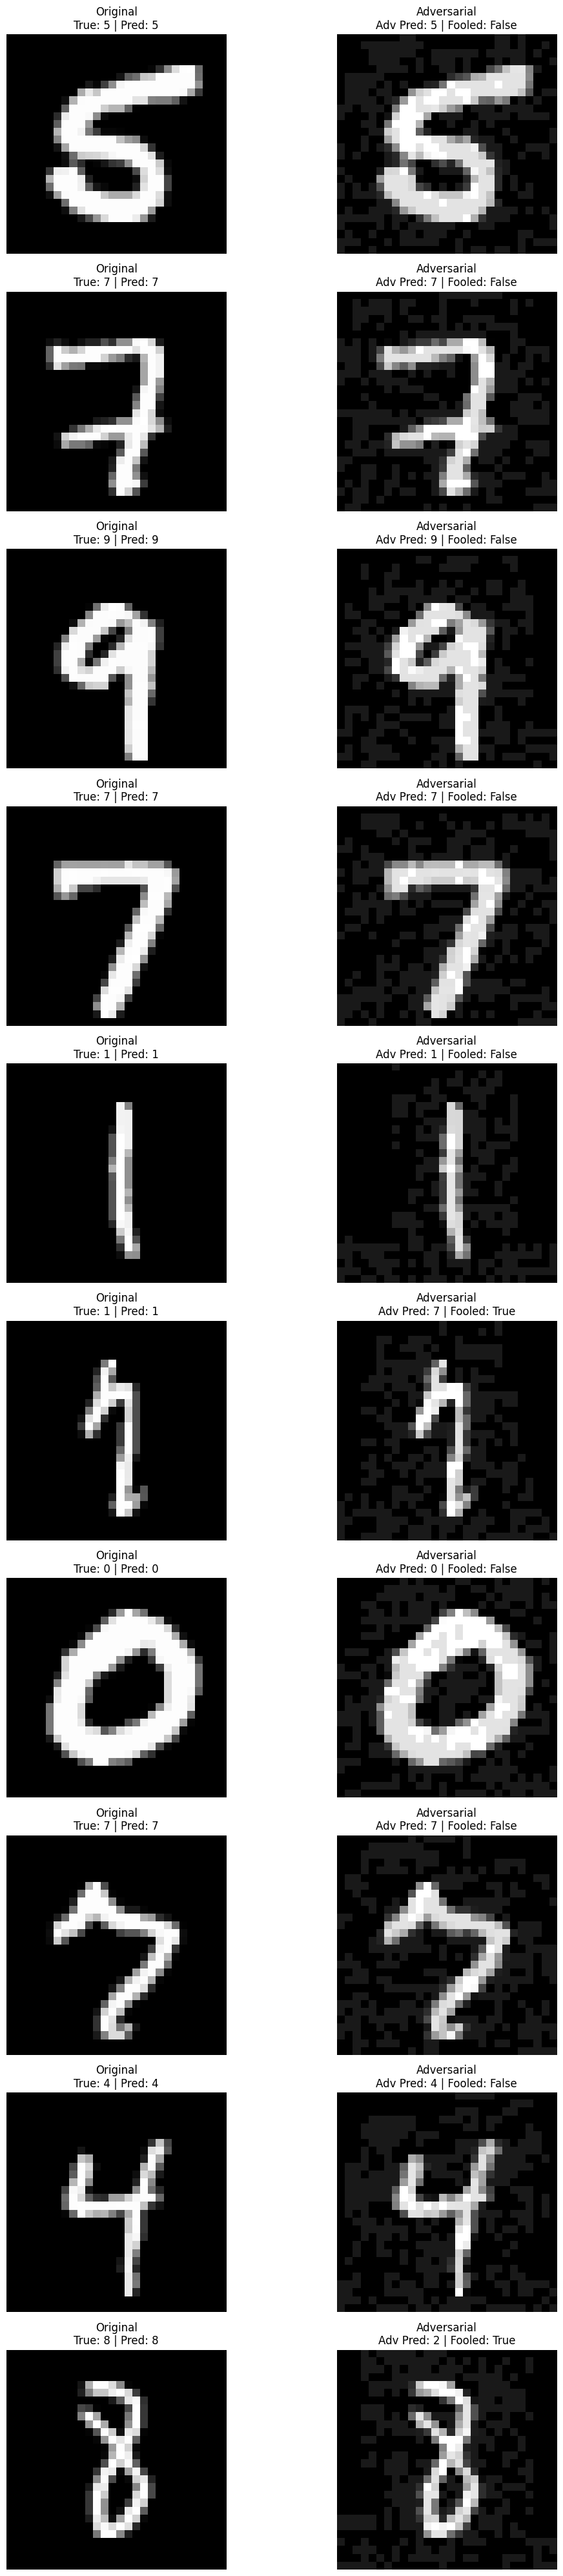

In [96]:
raw, clipped, is_adv = attack(fmodel, images, labels, epsilons=0.1)

# Get predictions
with torch.no_grad():
    orig_preds = model(images).argmax(dim=1)
    adv_preds = model(clipped).argmax(dim=1)

# Plot results
plot_adversarial_examples(images, clipped, labels, orig_preds, adv_preds, is_adv)


We show examples until we find an example where the model is tricked.

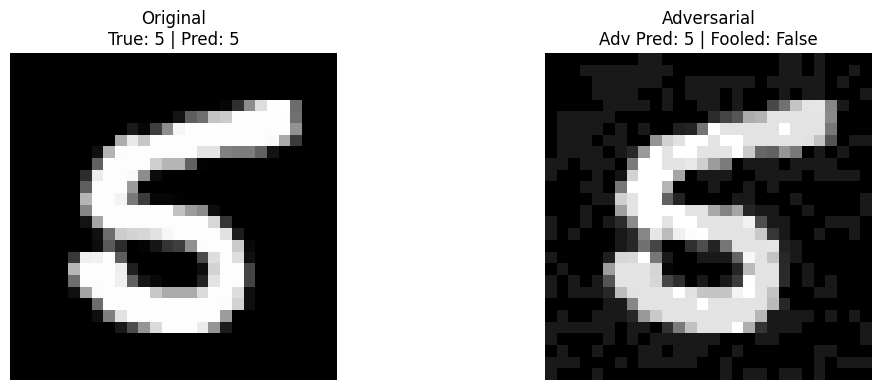

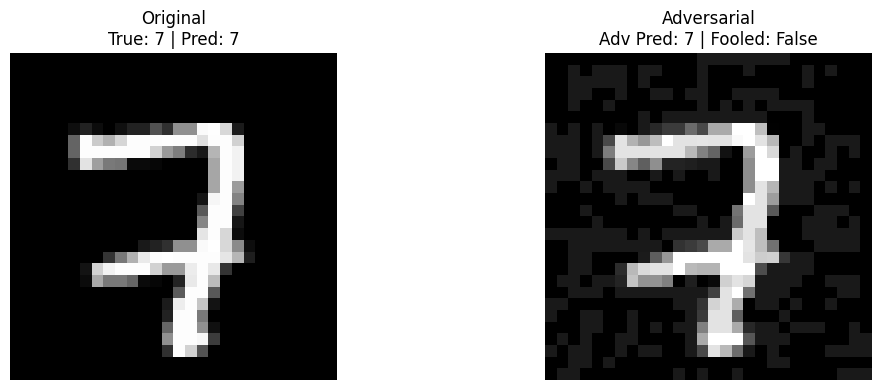

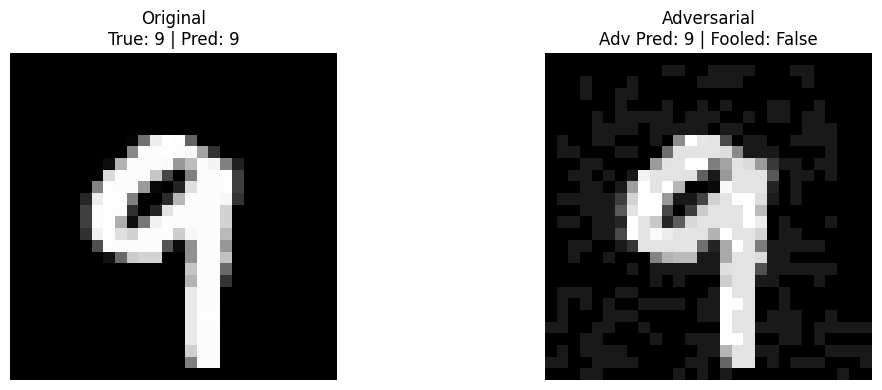

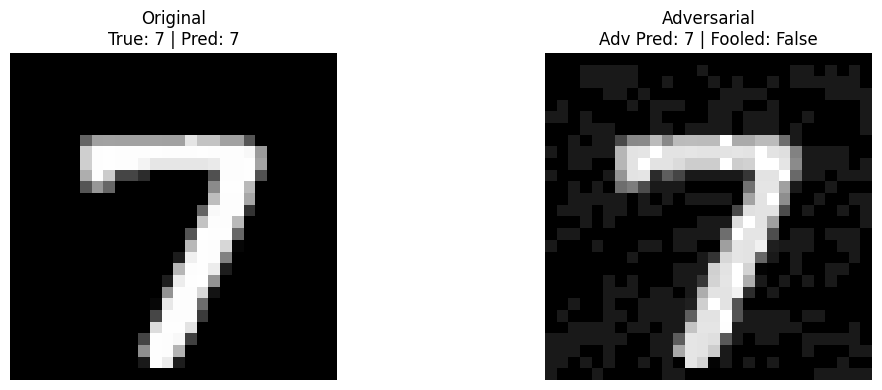

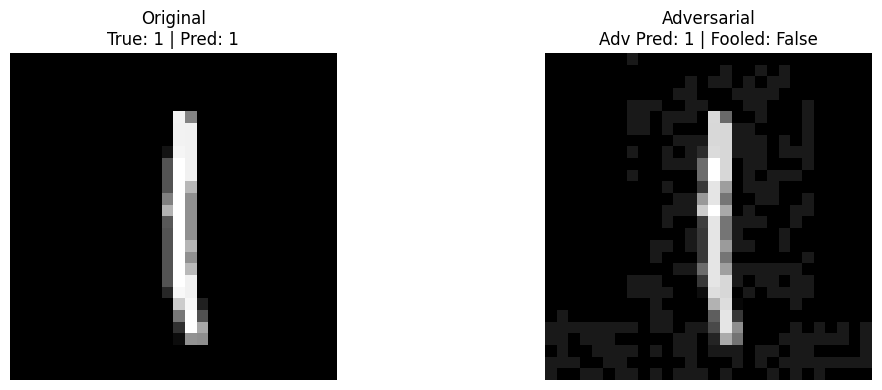

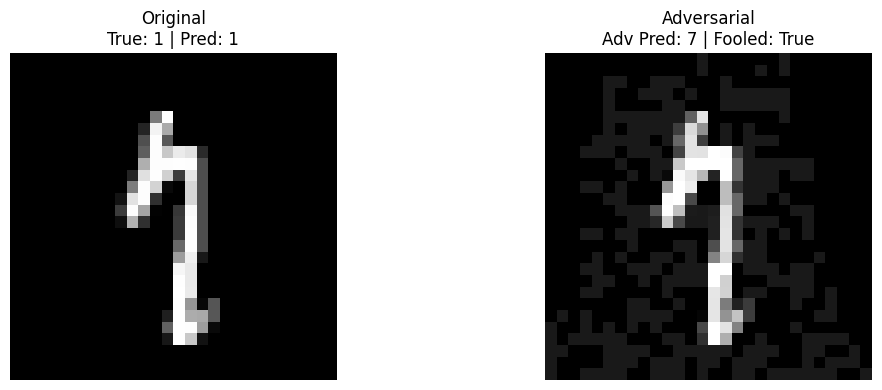

In [97]:
# Show an example of a fooled image
def show_example(images, adv_images, labels, predictions, adv_predictions, is_adv, index):
    images = images.cpu().detach()
    adv_images = adv_images.cpu().detach()
    labels = labels.cpu().numpy()
    predictions = predictions.cpu().numpy()
    adv_predictions = adv_predictions.cpu().numpy()
    is_adv = is_adv.cpu().numpy()

    plt.figure(figsize=(12, 4))
    
    # Original image
    plt.subplot(1, 2, 1)
    plt.imshow(images[index][0], cmap='gray')
    plt.title(f"Original\nTrue: {labels[index]} | Pred: {predictions[index]}")
    plt.axis('off')

    # Adversarial image
    plt.subplot(1, 2, 2)
    plt.imshow(adv_images[index][0], cmap='gray')
    plt.title(f"Adversarial\nAdv Pred: {adv_predictions[index]} | Fooled: {is_adv[index]}")
    plt.axis('off')

    plt.tight_layout()
    plt.show()
# Show an example of a fooled image

for i in range(len(is_adv)):
    show_example(images, clipped, labels, orig_preds, adv_preds, is_adv, i)
    if (is_adv[i] == 1):
        break